In [57]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import seaborn as sns

from pprint import pprint
import requests
import time
from datetime import datetime


### Notebook study: mass vs cost 
+ can normalize the values (5M - 20M rn), into relative
+ retrieve mass from discos


discos -- we treat as truth data for: NORAD ID, cosparID (launch yr), width, height, mass, object class


In [2]:
# DISCOSWEB, filter
URL = 'https://discosweb.esoc.esa.int'
token = 'ImI5MjBiMzM2LTk2ZjktNDA0ZC1hZGFiLTNjMmFiZjc4NGFkYSI.0_k20tZIVHaaq-89tngta3rmZd0'
# Dan's ESA API token^

headers = {
    'Authorization': f'Bearer {token}',
    'DiscosWeb-Api-Version': '2',
}

params = {
    # 'filter': "eq(objectClass,Payload)&gt(reentry.epoch,epoch:'2020-01-01')",
    # 'filter': "gt(reentry.epoch,epoch:'2024-01-01')",
    'sort': '-reentry.epoch',
    'page[size]': '100',
    'page[number]': '1'
}

response = requests.get(f"{URL}/api/objects", headers=headers, params=params)

# Check if request was successful
if response.status_code == 200:
    data = response.json()
    total_pages = data['meta']['pagination']['totalPages']
    print(f"Total Pages: {total_pages}")

# Store all results
discos_data = data['data']

# Fetch remaining pages in batches of 20 to avoid the rate limits
for page in range(2, total_pages + 1):
    if page > 1 and (page - 1) % 20 == 0:  # Every 20 pages, pause for 60 seconds
        print("\nRate limit handling: Pausing for 80 seconds...\n")
        time.sleep(80)

    print(f"Now fetching page {page}/{total_pages}...")

    params['page[number]'] = str(page)
    response = requests.get(f"{URL}/api/objects", headers=headers, params=params)

    if response.status_code == 200:
        new_data = response.json()['data']
        discos_data.extend(new_data)  # Append new results
    else:
        print(f"!!! Oh no, error fetching page {page}: {response.status_code}")
        break  # Stop fetching if an error occurs

print(f"Total objects retrieved: {len(discos_data)}")

Total Pages: 845
Now fetching page 2/845...
Now fetching page 3/845...
Now fetching page 4/845...
Now fetching page 5/845...
Now fetching page 6/845...
Now fetching page 7/845...
Now fetching page 8/845...
Now fetching page 9/845...
Now fetching page 10/845...
Now fetching page 11/845...
Now fetching page 12/845...
Now fetching page 13/845...
Now fetching page 14/845...
Now fetching page 15/845...
Now fetching page 16/845...
Now fetching page 17/845...
Now fetching page 18/845...
Now fetching page 19/845...
Now fetching page 20/845...

Rate limit handling: Pausing for 80 seconds...

Now fetching page 21/845...
Now fetching page 22/845...
Now fetching page 23/845...
Now fetching page 24/845...
Now fetching page 25/845...
Now fetching page 26/845...
Now fetching page 27/845...
Now fetching page 28/845...
Now fetching page 29/845...
Now fetching page 30/845...
Now fetching page 31/845...
Now fetching page 32/845...
Now fetching page 33/845...
Now fetching page 34/845...
Now fetching page 

In [3]:
# convert to pd dataframe, then save pkl

discos_attrs = [entry["attributes"] for entry in discos_data if "attributes" in entry]
satnos = [entry["satno"] for entry in discos_attrs]

seen = set()
dedup_discos = []
for entry in discos_attrs:
    satno = entry["satno"]
    if satno not in seen:
        seen.add(satno)
        dedup_discos.append(entry)

# Convert to DataFrame
discos_df = pd.DataFrame(dedup_discos)
# print(f"DISCOS data with NORAD satno: {len(dedup_discos)} / {len(discos_data)} ({len(dedup_discos)/len(discos_data)*100:.1f}%)")
# print("Sample objectClass values from DISCOS:")
# print(discos_df["objectClass"].value_counts(dropna=False))

# Save pickle file
discos_df.to_pickle('raw_discos_jun25.pkl')

In [4]:
print(discos_df.head(-5))
print(list(discos_df.columns))
print(f"DISCOS data number of objects: {len(discos_data)}")

         cosparId  vimpelId    satno                             name  \
0      2023-064AB       NaN  56473.0                    Starlink 5486   
1       2023-020K       NaN  55578.0                    Starlink 5713   
2      2020-035AK       NaN  45690.0                    Starlink 1414   
3       2024-137B       NaN  60353.0  Lunar Photon (Electron (Curie))   
4      2024-140AT       NaN  60642.0                 CZ-6A Y21 debris   
...           ...       ...      ...                              ...   
52058  1993-016AF       NaN  22645.0     Zenit-2 fragmentation debris   
52059   1988-077E   68700.0  22669.0     Titan 34D operational debris   
52060   1994-023E       NaN  23091.0  Zenit-2 satellite ejection unit   
52061   1994-023F       NaN  23094.0  Zenit-2 satellite ejection unit   
52062   2024-224K       NaN  62148.0                   Starlink 32479   

                         objectClass   mass        shape  width  height  \
0                            Payload  305.0  Box

In [5]:
# test w old discos 
# INCOMPLETE Discos ---------------------------------
# discos_df = pd.read_pickle("/Users/isabellavesely/pyssem/pyssem/utils/notebooks/raw_discos_jun25.pkl")
# discos_df

In [59]:
kmi_file = '/Users/isabellavesely/pyssem/pyssem/utils/notebooks/sat_cost.xlsx'

kmi_df = pd.read_excel(kmi_file)
print(kmi_df.head(-5))

       Object Number (NORAD CAT ID?)   objectType country  Mission Cost
0                                 22    Satellite      US      20139400
1                                 29    Satellite      US      20396100
2                                 45    Satellite      US      21651600
3                                 46    Satellite      US      21290700
4                                 47  Rocket Body      US      22697600
...                              ...          ...     ...           ...
12257                          63742    Satellite      US      18213300
12258                          63743    Satellite      US      18217800
12259                          63744    Satellite      US      18218400
12260                          63745    Satellite      US      18215100
12261                          63746    Satellite      US      18231600

[12262 rows x 4 columns]


In [7]:
# combine 2 dfs, match by Norad ID (satno for discos)
df_cost = kmi_df.rename(columns={"Object Number (NORAD CAT ID?)": "NORAD"})
df_mass = discos_df.rename(columns={"satno": "NORAD"})
df_merged = pd.merge(df_cost, df_mass, on='NORAD', how='inner')
print(f"Number of total merged entries -------------- {len(df_merged)}")

df_merged = df_merged.dropna(subset=['mass'])  # Keep only complete rows
print(f"Number of merged entries with known mass ---- {len(df_merged)}")

Number of total merged entries -------------- 7359
Number of merged entries with known mass ---- 5616


In [8]:
df_merged


,NORAD,objectType,country,Mission Cost,cosparId,vimpelId,name,objectClass,mass,shape,...,span,xSectMax,xSectMin,xSectAvg,firstEpoch,mission,predDecayDate,active,cataloguedFragments,onOrbitCataloguedFragments
0,22,Satellite,US,20139400,1959-009A,NaN,Explorer 7,Payload,41.13,Cone + Cone,...,0.76,0.453646,0.453646,0.453646,1959-10-13,Civil Science,2029-07-22,None,0,0
1,29,Satellite,US,20396100,1960-002B,NaN,Tiros I,Payload,118.93,Cyl,...,1.07,1.035543,0.513600,0.852982,1960-04-01,Civil Weather,2056-04-29,None,0,0
2,45,Satellite,US,21651600,1960-007A,NaN,Transit 2A,Payload,100.10,Sphere,...,0.91,0.650400,0.650400,0.650400,1960-06-22,Defense Navigation,2090-08-18,None,0,0
3,46,Satellite,US,21290700,1960-007B,NaN,Greb,Payload,18.83,Sphere,...,0.30,0.204300,0.204300,0.204300,1960-06-22,Defense Sigint,2045-08-04,None,0,0
4,47,Rocket Body,US,22697600,1960-007C,NaN,Able-Star (Thor-Ablestar),Rocket Body,445.99,Cyl,...,4.80,6.894062,1.539380,6.047566,1960-06-22,None,2067-10-21,None,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7326,63496,Satellite,US,8409700,2025-071D,NaN,Starlink 33829,Payload,575.00,Box + 1 Pan,...,29.00,111.036204,1.230000,41.120267,2025-04-11,Commercial Communications,None,True,0,0
7327,63497,Satellite,US,8238600,2025-071E,NaN,Starlink 33815,Payload,575.00,Box + 1 Pan,...,29.00,111.036204,1.230000,41.120267,2025-04-11,Commercial Communications,None,True,0,0
7328,63498,Satellite,US,8348300,2025-071F,NaN,Starlink 33833,Payload,575.00,Box + 1 Pan,...,29.00,111.036204,1.230000,41.120267,2025-04-11,Commercial Communications,None,True,0,0
7329,63499,Satellite,US,8348200,2025-071G,NaN,Starlink 33534,Payload,575.00,Box + 1 Pan,...,29.00,111.036204,1.230000,41.120267,2025-04-11,Commercial Communications,None,True,0,0


## Unnormalized mass vs mission cost

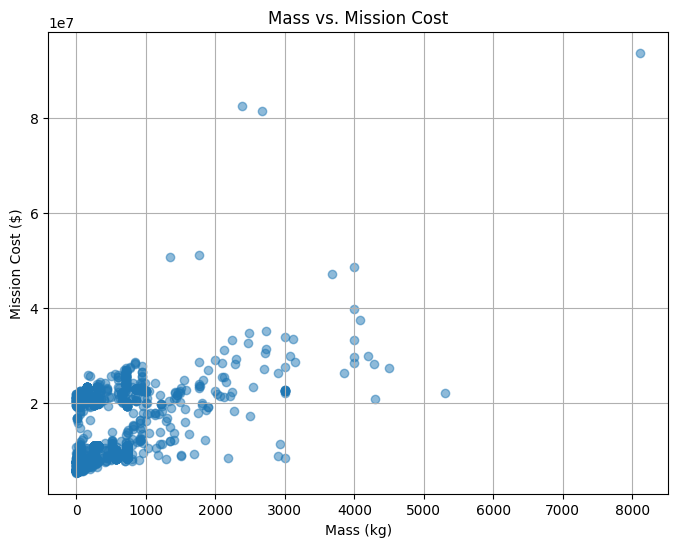

In [9]:
plt.figure(figsize=(8, 6))

plt.scatter(df_merged['mass'], df_merged['Mission Cost'], alpha=0.5) # CHECK not mass_kg name

plt.xlabel("Mass (kg)")
plt.ylabel("Mission Cost ($)")
plt.title("Mass vs. Mission Cost")
plt.grid(True)
plt.show()

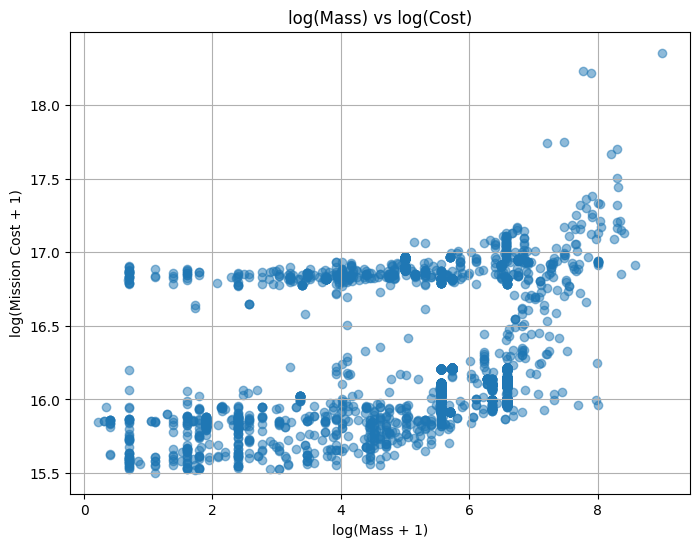

In [ ]:
# log - log: not very enlightening either

plt.figure(figsize=(8, 6))
plt.scatter(np.log1p(df_merged['mass']), np.log1p(df_merged['Mission Cost']), alpha=0.5)
plt.xlabel("log(Mass + 1)")
plt.ylabel("log(Mission Cost + 1)")
plt.title("log(Mass) vs log(Cost)")
plt.grid(True)
plt.show()


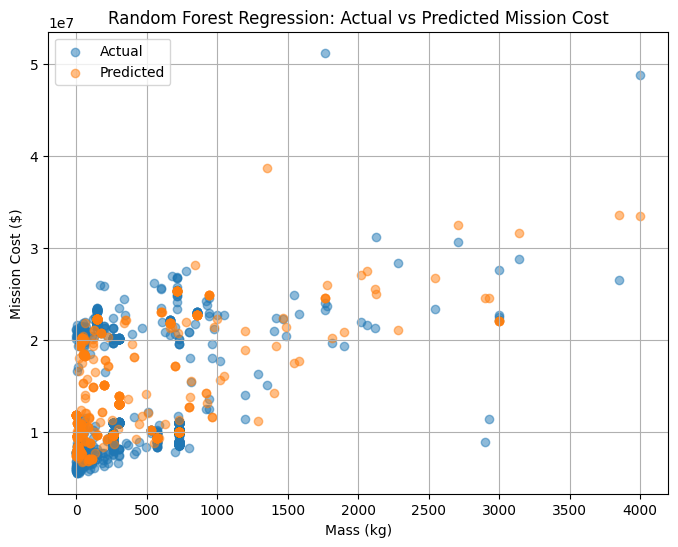

(0.5471358959171291, 3771823.0489450963, 14226649112553.482)

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error

X = df_merged[['mass']]
y = df_merged['Mission Cost']

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

# Random Forest Regressor
rf = RandomForestRegressor(n_estimators=50, random_state=42)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

# Add predictions to df for plotting
df_plot = X_test.copy()
df_plot['Actual'] = y_test
df_plot['Predicted'] = y_pred

# Plot actual vs predicted
plt.figure(figsize=(8, 6))
plt.scatter(df_plot['mass'], df_plot['Actual'], label='Actual', alpha=0.5)
plt.scatter(df_plot['mass'], df_plot['Predicted'], label='Predicted', alpha=0.5)
plt.xlabel('Mass (kg)')
plt.ylabel('Mission Cost ($)')
plt.title('Random Forest Regression: Actual vs Predicted Mission Cost')
plt.legend()
plt.grid(True)
plt.show()

r2 = r2_score(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)
mse = mean_squared_error(y_test, y_pred)

r2, rmse, mse
# pretty trash, not good explanation of variance

## Min-max normalization (in [0,1]) mass vs mission cost

In [11]:
df_merged['mass']

0         41.13
1        118.93
2        100.10
3         18.83
4        445.99
         ...   
7326     575.00
7327     575.00
7328     575.00
7329     575.00
7358    1170.00
Name: mass, Length: 5616, dtype: float64

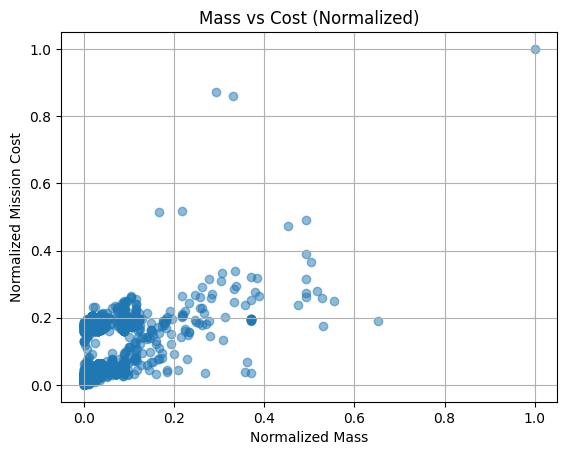

In [12]:
# normalize to [0, 1]
df_merged['mass_norm'] = (df_merged['mass'] - df_merged['mass'].min()) / (df_merged['mass'].max() - df_merged['mass'].min())
df_merged['cost_norm'] = (df_merged['Mission Cost'] - df_merged['Mission Cost'].min()) / (df_merged['Mission Cost'].max() - df_merged['Mission Cost'].min())

#plot
# plt.figure(figsize=(8, 6))
plt.scatter(df_merged['mass_norm'], df_merged['cost_norm'], alpha=0.5)
plt.xlabel("Normalized Mass")
plt.ylabel("Normalized Mission Cost")
plt.title("Mass vs Cost (Normalized)")
plt.grid(True)
plt.show()

/Users/isabellavesely/opt/anaconda3/envs/anacondaEnv/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


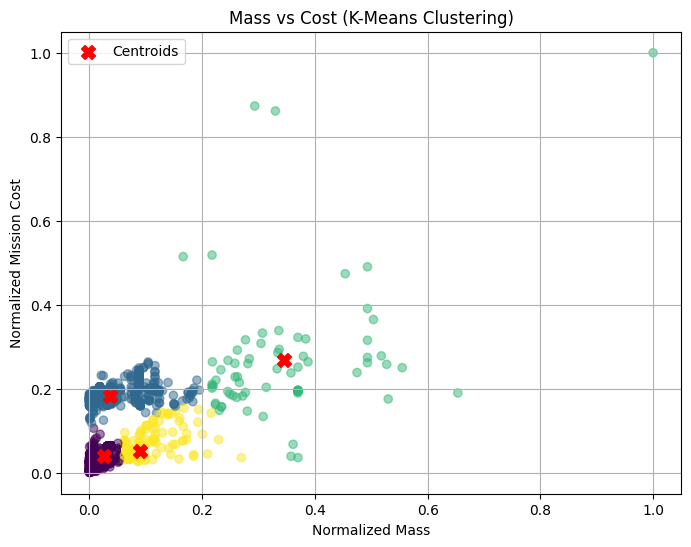

In [23]:
X = df_merged[['mass_norm', 'cost_norm']].values

kmeans = KMeans(n_clusters=4, random_state=42)
df_merged['cluster'] = kmeans.fit_predict(X)
centroids = kmeans.cluster_centers_

plt.figure(figsize=(8, 6))
plt.scatter(df_merged['mass_norm'], df_merged['cost_norm'], c=df_merged['cluster'], cmap='viridis', alpha=0.5)
plt.scatter(centroids[:, 0], centroids[:, 1], c='red', s=100, marker='X', label='Centroids')
plt.xlabel("Normalized Mass")
plt.ylabel("Normalized Mission Cost")
plt.title("Mass vs Cost (K-Means Clustering)")
plt.legend()
plt.grid(True)
plt.show()

# df_merged.groupby('cluster')[['mass', 'Mission Cost']].describe()


/Users/isabellavesely/opt/anaconda3/envs/anacondaEnv/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/isabellavesely/opt/anaconda3/envs/anacondaEnv/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/isabellavesely/opt/anaconda3/envs/anacondaEnv/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/isabellavesely/opt/anaconda3/envs/anacondaEnv/lib/pyth

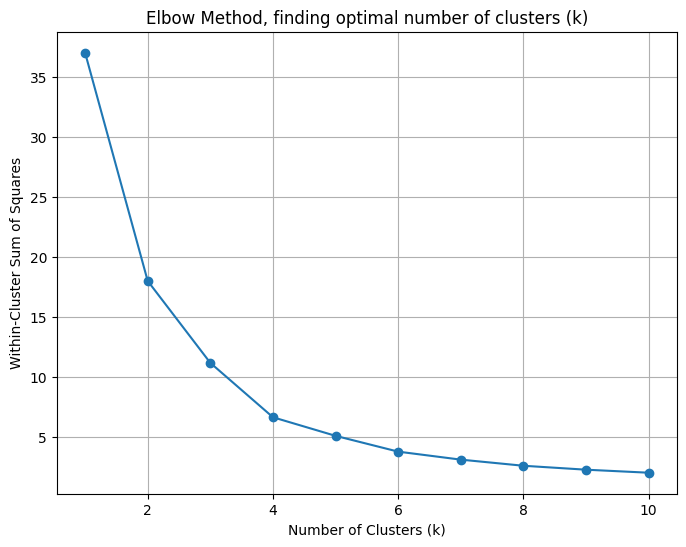

In [27]:
inertias = []
K_range = range(1, 11)  # Try k from 1 to 10

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X)
    inertias.append(kmeans.inertia_)

plt.figure(figsize=(8, 6))
plt.plot(K_range, inertias, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Within-Cluster Sum of Squares')
plt.title('Elbow Method, finding optimal number of clusters (k)')
plt.grid(True)
plt.show()

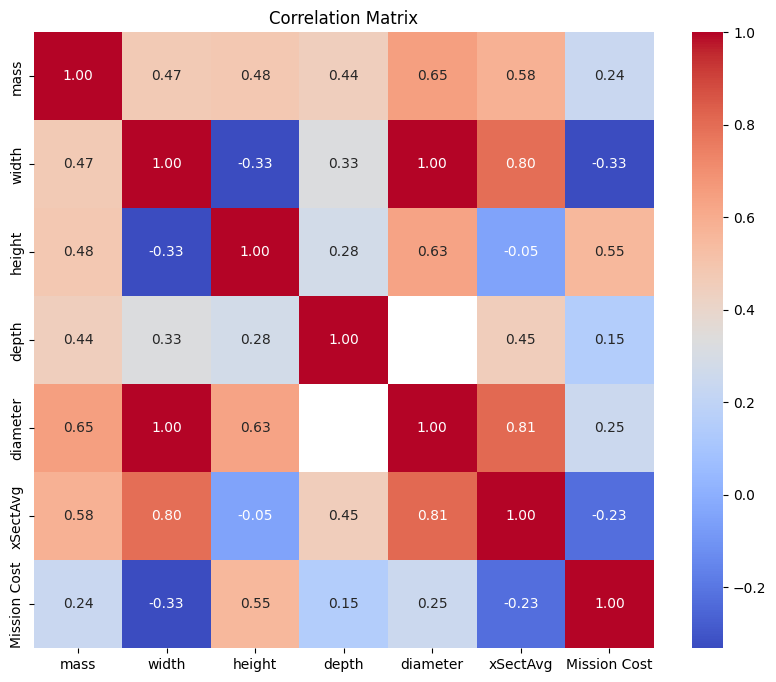

In [33]:
numeric_cols = ['mass', 'width', 'height', 'depth', 'diameter', 'xSectAvg', 'Mission Cost']
corr = df_merged[numeric_cols].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix")
plt.show()


In [48]:
df_encoded

,NORAD,country,Mission Cost,cosparId,vimpelId,name,objectClass,mass,shape,width,...,predDecayDate,active,cataloguedFragments,onOrbitCataloguedFragments,mass_norm,cost_norm,cluster,height_norm,objectType_Rocket Body,objectType_Satellite
0,22,US,20139400,1959-009A,NaN,Explorer 7,Payload,41.13,Cone + Cone,0.76,...,2029-07-22,None,0,0,0.005041,0.166817,1,0.027247,False,True
1,29,US,20396100,1960-002B,NaN,Tiros I,Payload,118.93,Cyl,NaN,...,2056-04-29,None,0,0,0.014634,0.169723,1,0.016867,False,True
2,45,US,21651600,1960-007A,NaN,Transit 2A,Payload,100.10,Sphere,0.91,...,2090-08-18,None,0,0,0.012312,0.183935,1,0.032808,False,True
3,46,US,21290700,1960-007B,NaN,Greb,Payload,18.83,Sphere,0.30,...,2045-08-04,None,0,0,0.002291,0.179850,1,0.010195,False,True
4,47,US,22697600,1960-007C,NaN,Able-Star (Thor-Ablestar),Rocket Body,445.99,Cyl,NaN,...,2067-10-21,None,0,0,0.054963,0.195776,1,0.177016,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7326,63496,US,8409700,2025-071D,NaN,Starlink 33829,Payload,575.00,Box + 1 Pan,4.10,...,None,True,0,0,0.070871,0.034039,3,0.010195,False,True
7327,63497,US,8238600,2025-071E,NaN,Starlink 33815,Payload,575.00,Box + 1 Pan,4.10,...,None,True,0,0,0.070871,0.032102,3,0.010195,False,True
7328,63498,US,8348300,2025-071F,NaN,Starlink 33833,Payload,575.00,Box + 1 Pan,4.10,...,None,True,0,0,0.070871,0.033344,3,0.010195,False,True
7329,63499,US,8348200,2025-071G,NaN,Starlink 33534,Payload,575.00,Box + 1 Pan,4.10,...,None,True,0,0,0.070871,0.033343,3,0.010195,False,True


In [54]:
numeric_cols

,NORAD,Mission Cost,vimpelId,mass,width,height,depth,diameter,span,xSectMax,xSectMin,xSectAvg,cataloguedFragments,onOrbitCataloguedFragments,mass_norm,cost_norm,cluster,height_norm,objectType_binary
0,22,20139400,NaN,41.13,0.76,0.76,0.76,NaN,0.76,0.453646,0.453646,0.453646,0,0,0.005041,0.166817,1,0.027247,1.0
1,29,20396100,NaN,118.93,NaN,0.48,NaN,1.07,1.07,1.035543,0.513600,0.852982,0,0,0.014634,0.169723,1,0.016867,1.0
2,45,21651600,NaN,100.10,0.91,0.91,0.91,NaN,0.91,0.650400,0.650400,0.650400,0,0,0.012312,0.183935,1,0.032808,1.0
3,46,21290700,NaN,18.83,0.30,0.30,0.30,NaN,0.30,0.204300,0.204300,0.204300,0,0,0.002291,0.179850,1,0.010195,1.0
4,47,22697600,NaN,445.99,NaN,4.80,NaN,1.40,4.80,6.894062,1.539380,6.047566,0,0,0.054963,0.195776,1,0.177016,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7326,63496,8409700,NaN,575.00,4.10,0.30,4.10,NaN,29.00,111.036204,1.230000,41.120267,0,0,0.070871,0.034039,3,0.010195,1.0
7327,63497,8238600,NaN,575.00,4.10,0.30,4.10,NaN,29.00,111.036204,1.230000,41.120267,0,0,0.070871,0.032102,3,0.010195,1.0
7328,63498,8348300,NaN,575.00,4.10,0.30,4.10,NaN,29.00,111.036204,1.230000,41.120267,0,0,0.070871,0.033344,3,0.010195,1.0
7329,63499,8348200,NaN,575.00,4.10,0.30,4.10,NaN,29.00,111.036204,1.230000,41.120267,0,0,0.070871,0.033343,3,0.010195,1.0


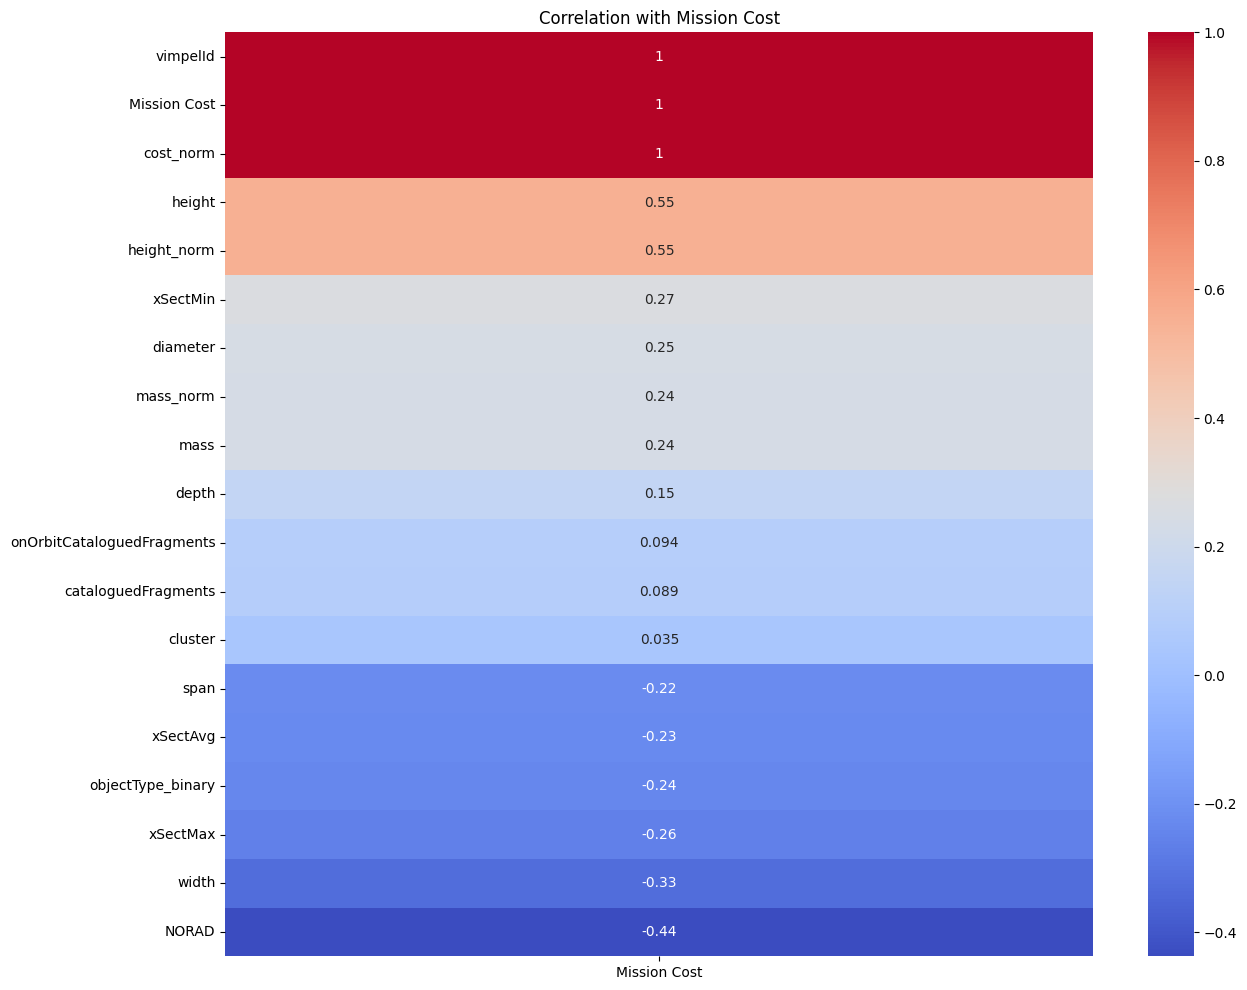

In [55]:
# One-hot encode objectClass
df_merged2 = df_merged.copy()
df_merged2['objectType_binary'] = df_merged2['objectType'].map({'Satellite': 1, 'Rocket Body': 0})

numeric_cols = df_merged2.select_dtypes(include='number')

corr = numeric_cols.corr()
plt.figure(figsize=(14, 12))
sns.heatmap(corr[['Mission Cost']].sort_values('Mission Cost', ascending=False), annot=True, cmap='coolwarm')
plt.title("Correlation with Mission Cost")
plt.show()


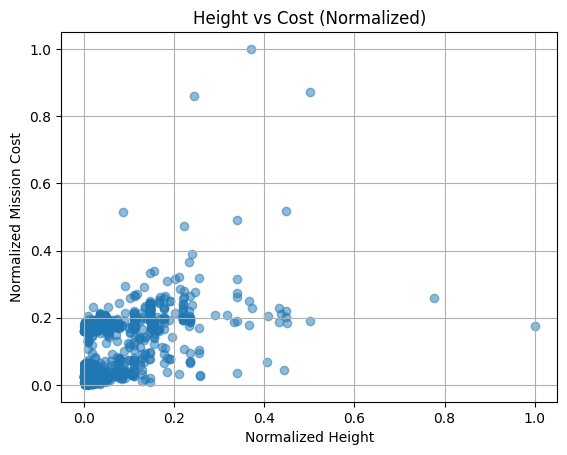

In [37]:
# normalize to [0, 1]
df_merged['height_norm'] = (df_merged['height'] - df_merged['height'].min()) / (df_merged['height'].max() - df_merged['height'].min())
df_merged['cost_norm'] = (df_merged['Mission Cost'] - df_merged['Mission Cost'].min()) / (df_merged['Mission Cost'].max() - df_merged['Mission Cost'].min())

#plot
# plt.figure(figsize=(8, 6))
plt.scatter(df_merged['height_norm'], df_merged['cost_norm'], alpha=0.5)
plt.xlabel("Normalized Height")
plt.ylabel("Normalized Mission Cost")
plt.title("Height vs Cost (Normalized)")
plt.grid(True)
plt.show()